In [1]:
# 基本のライブラリを読み込む
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats

# 統計モデルを推定するライブラリ
import statsmodels.api as sm
import statsmodels.tsa.api as tsa

# sktime：グラフ描画
from sktime.utils.plotting import plot_series

# 再帰的に回帰分析を実行するための関数の読み込み
from sklearn.linear_model import LinearRegression
from sktime.forecasting.compose import make_reduction

# sktime：予測の評価
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import (
    mean_absolute_scaled_error,
    MeanAbsoluteError,
    mean_absolute_percentage_error,
    mean_absolute_error,
)

# グラフを描画するライブラリ
from matplotlib import pylab as plt
import seaborn as sns
import matplotlib.dates as mdates

sns.set()

# グラフの日本語表記
from matplotlib import rcParams

rcParams["font.family"] = "IPAexGothic"
rcParams["font.sans-serif"] = "Meiryo"

In [2]:
# 表示設定
np.set_printoptions(linewidth=60)
pd.set_option("display.width", 80)

from matplotlib.pylab import rcParams

rcParams["figure.figsize"] = 8, 4

In [3]:
# 乱数の種
np.random.seed(1)

# 正規分布に従う乱数の累積和を作成し、ランダムウォーク系列を作る
sim_size = 100
rw = pd.DataFrame(
    {"rw": np.cumsum(stats.norm.rvs(loc=0, scale=1, size=sim_size))},
    index=pd.date_range(start="2000-01-01", periods=sim_size, freq="D"),
)

In [4]:
# 欠測入りの系列
rw_missing = rw.copy()

# 1時点を欠測とする
rw_missing.loc["2000-01-03"] = None

# 結果の確認
print(rw_missing.head())

                  rw
2000-01-01  1.624345
2000-01-02  1.012589
2000-01-03       NaN
2000-01-04 -0.588551
2000-01-05  0.276856


In [5]:
# 欠測値の補間処理
# ------------------------------------------------------------
# 欠測データ（NaN）が存在する場合、interpolate() により線形補間を行う。
# この関数は、前後の有効なデータ点をもとに、連続的な値を推定する。
# ------------------------------------------------------------
# 例：
#   欠測値が含まれる時系列：
#     [1.0, NaN, NaN, 4.0]
#   線形補間後：
#     [1.0, 2.0, 3.0, 4.0]
#
# 理論的には、線形補間は次の式で与えられる：
#     y_i = y_{t-1} + (y_{t+1} - y_{t-1}) * ((x_i - x_{t-1}) / (x_{t+1} - x_{t-1}))
# すなわち、時点 i の値を、前後の観測値の線形結合で推定する。
# ------------------------------------------------------------
# 欠測値が多い場合は、移動平均・スプライン補間・Kalmanフィルタ補間などを検討する。
# ------------------------------------------------------------

print(rw_missing.interpolate().head())

                  rw
2000-01-01  1.624345
2000-01-02  1.012589
2000-01-03  0.212019
2000-01-04 -0.588551
2000-01-05  0.276856


In [6]:
# interpolateメソッドを使わない実装
(rw_missing.loc["2000-01-02"] + rw_missing.loc["2000-01-04"]) / 2

rw    0.212019
dtype: float64

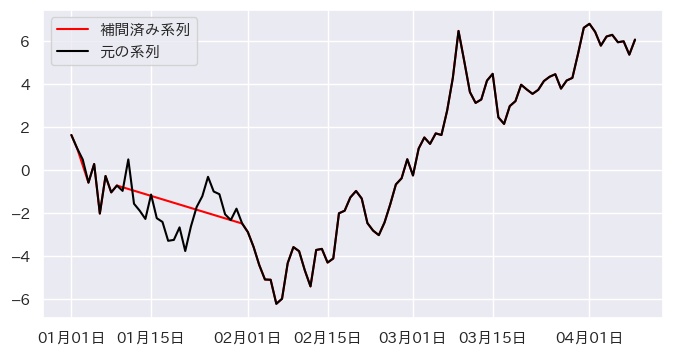

In [7]:
# 21時点連続で欠測
rw_missing.loc["2000-01-10":"2000-01-30"] = None

# グラフサイズの指定
fig, ax = plt.subplots(figsize=(8, 4))

# 折れ線グラフを描く
ax.plot(rw_missing.interpolate(), label="補間済み系列", color="red")
ax.plot(rw, label="元の系列", color="black")

# 凡例
ax.legend()

# 軸ラベルのフォーマット
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m月%d日"))

In [8]:
# 飛行機乗客数データの読み込み
air_passengers = sm.datasets.get_rdataset("AirPassengers").data

# 日付インデックスの作成(DatetimeIndex)
date_index = pd.date_range(start="1949-01", periods=len(air_passengers), freq="MS")
air_passengers.index = date_index

# 不要な時間ラベルの削除
air_passengers = air_passengers.drop(air_passengers.columns[0], axis=1)

In [9]:
# データの2年間を欠測にする
air_passengers.loc["1955":"1956"] = None

In [10]:
# ローカルレベルモデル
mod_ll = tsa.UnobservedComponents(
    air_passengers, level="local level"  # 対象データ  # ローカルレベル
).fit()

# 季節変動ありのローカル線形トレンドモデル
mod_bsts = tsa.UnobservedComponents(
    air_passengers,  # 対象データ
    level="local linear trend",  # ローカル線形トレンド
    seasonal=12,  # 周期
).fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.85136D+00    |proj g|=  5.10240D-03

At iterate    5    f=  4.09645D+00    |proj g|=  8.10081D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5     15      1     0     0   8.101D-06   4.096D+00
  F =   4.0964480013774169     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.


<Axes: >

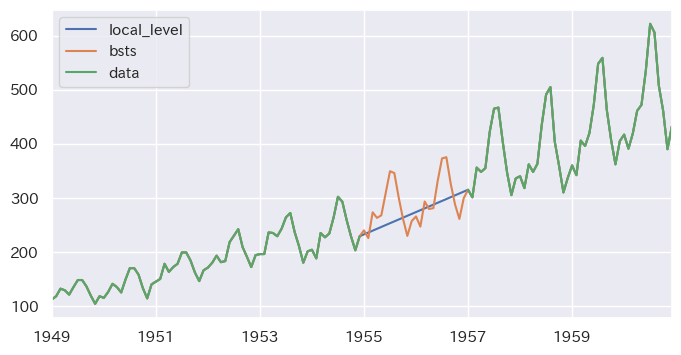

In [11]:
# DataFrameにまとめる
plot_df = pd.DataFrame(
    {
        "local_level": mod_ll.level["smoothed"],
        "bsts": mod_bsts.level["smoothed"] + mod_bsts.seasonal["smoothed"],
        "data": air_passengers["value"],
    }
)

# 可視化
plot_df.plot()